##**MASTERMIND GAME**##



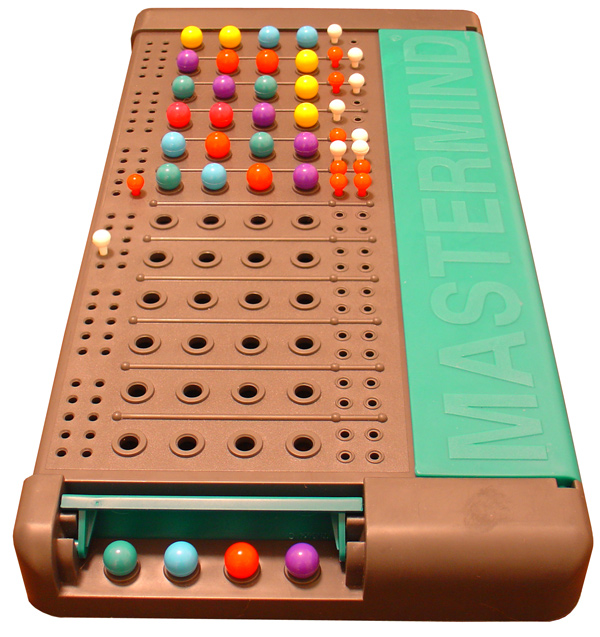









**Explanation of the game:**

This game is played by two players. 

the first player starts by creating a list of plegs. All the plegs have a specific colors. This list will be the secret during all the game, and the second player can never know it. 
The target of the second player is to guess this secret list. He can do only a specific number of guesses. 
* If he find the secret before reaching the maximal number of tests: He WON the game. 
* If he did many guesses until reaching the maximal possible number of tests: He LOSS the game. 


**Course of the game:**
* STEP 1: Creating the secret list. 
* STEP 2: Do a guess. 
* STEP 3: Evaluate the similarity between the Guess and the Secret. 
* STEP 4: Check if the guess and the secret are identical. 
* STEP 4: If they are not the same, test another guess taking into account the previous evaluation. 
* STEP 5: Since we didn't reached the maximal number of possible guesses, we will continue this process until finding the secret or until reaching the maximal number of guess. 

**Adapting the game to the code:**

This game can be played with:
* A player and a computer. 
* A player vs a player 
* A computer vs a computer. 

Here, we will do it only with the computer.





We import the modules. 

In [ ]:
from random import * 
import time
import itertools
import numpy as np

A function that takes in argument the size of the list, and a range of number. 
It return a list of size niv and with radom values between 0 and nb_color-1. 

This function will build us lists with random values. We will use it to build the secret and our first guess. 

In [ ]:
def random_list(niv = 4, nb_color = 6): ## 4 and 6 are the values by default 
  return  [randint(0,nb_color-1) for i in range(niv)] # example secret=['1','4','4','5'] (the number are the colors)

A function to initialize all the possible guesses. 
For example if we work with 6 colors and 4 plots, we will obtain 6^4=1296 possible guesses. 
The function will return us all the combinations from 1 to nb_color. 

In [ ]:

def possible_answers(niv=4,nb_color = 6):
    possible_answers= list(itertools.product(np.arange(0, nb_color, 1), repeat=niv))
    return np.array(possible_answers).tolist()

This function takes in argument our guess and the Secret. 
It returns us a tuple of 2 numbers. 

A function to evaluate the current guess - 
It returns a tuple of Black, White. 
* Black represents the pleg in the Guess that are in the same color and in the same position than a pleg in the Secret. 
* White represents the pleg in the Guess that have the same color than one of the pleg of the Secret, but these 2 plegs are not in the same positions.

For example [1,1,1,0] and [1,2,0,3] will give us:
* One Black: We have the same number 1 in the same position 0. 
* One White: We have the same number 0 but in different positions (the position 3 for the first list and the position 2 for the second list)

In [ ]:
def evaluate(guess,secret): 
    code=list(secret) # we make a copy of our secret since each time that we will make a change in copy, it will not make a change in secret. 
    guess_copy=list(guess)
    well_placed, bad_placed =0,0
    for i,j in enumerate(guess_copy): #enumarate([ 1,1,2,4]) return [(0,'1'),(1,'1'),(2,'2'),(3,'4')]
        if j==code[i]: #well-placed 
            well_placed+=1
            guess_copy[i]='#' #we do that in order to know count it a second time when we will verify the badly_placed
            code[i]='*'
    for j in guess_copy:
        if j in code:
            bad_placed +=1
            code[code.index(j)]='*'
    evaluation=(well_placed, bad_placed)
    return evaluation

An heuristic function that takes in arguments all the possible guesses, the evaluation that we have between the secret and an old guess, and a list S. 
This function returns us the new best guess and the list S. 


After having done the first guess, we want to take the information from this guess in order to improve the next guess. 
We would like to know thanks to the first evaluation between the previous guess and the secret each pegs are good in the guess. 
For example, if we obtain one Black and one White, we would like to know wich peg corespond to BLACK (the peg from the guess wich is identical to the pleg of secret) and then , in the next guess we will keep it in the same place and with the same color. 
when we compare secret=1234 and guess=0213 we obtain 2 white and 1 black. 
Now which plegs will we choose for the next guess? 
- Randomly choose the pegs : 1/6^4 -1 probaility to have the good one.It is a BAD SOLUTION 
- Getting information by using the previous Guess. But HOW? 
We know that we have 2 plegs that are with the good color but in the bad places and 1 pleg that is in the good color and in the good place. 
We would like to keep the pleg in the good place until the end of the game, and put the plegs with the good colors and bad places in another place. 
Problem: Wich pleg corespond to the good one? is it 0, 2, 1 or 3? 
we will first build an array of S=all possible answers. and we would like to decrease the size of this array, to increase the probabiliy to choose the secret. 
In fact, in the beginning size(S)=1296 so we have probability=1/1296 to choose the secret and win the game in the next game. 
Then, we will remove all the possible answers that have an evaluation different from the eval(guess1, secret) 
We know that secret ∈ S, because eval(secret,guess)=eval(guess1,secret) =>Symetric function. 
So removing all the answers that have a different evaluation, will give us: size(S)=n1 so probability=1/n1 and n1<1296 so (1/n1) > (1/1296) and so probability after removing> probability before. 
For example: 0321 give us the same eval so 0321 ∈ S, but 1224 ∉ S. 
then we have a bigger probability to find the  secret in the new array S. 

Now, we would like to increase our probability and we would like to reach size(S)=1: HOW? 
Divided S and choose the partition that have the bigger probability to contain the secret. HOW to divide S? 
We calculate the evaluation between elements of S and all the possibile answers. 
We obtain a partition of S over all the possible answers and the different evaluation. The card of each partition is the score. 
Then, we choose the maximal score for all possible answers: we consider the score that came up the most often, because  maximal score => the biggest partition=> S will have a bigger probability to be there and to not eliminate secret. 
In fact, Secret have more probability to be in ensemble of size 200 than 100 because of randomality.It is different from what we explained before, because after having divide S in the groups S1,S2,..,Sk, We don't know in which partition the secret is. So secret has more probability to be in the biggest ensemble in contrary of what we have explained before.  
Then, we choose the minimum from all score and the answer associated: Increasing the probability with smallest ensemble.
The score of a guess is the minimum number of possibilities it might eliminate from S.

In [ ]:
def heuristic(possible_answers,guess,eval_secret, S):
    
    #we create S
    new_list = S.copy()
    for ele in new_list: 
        if evaluate(guess,ele)!=eval_secret:
            S.remove(ele)
        
    #we create the table with score to all the possible answer        

    max_score=[]
    
    for ele in possible_answers: 
        dict_score={}
        for state in S:
            eval_score=evaluate(ele,state)
            if eval_score in dict_score:
                dict_score[(eval_score)]=dict_score[(eval_score)]+1
                
            else:
                dict_score[(eval_score)]=1
                
        max_value=0
        for score_key in dict_score:
            lenght=dict_score[(score_key)]
            if lenght>max_value:
                max_value=lenght
                
        max_score.append(max_value)  #we have the maximum of each ele in possible_answers
    
    best_guess=[]
    mini=1296 # all the possibilites
    for ele in max_score:
        if ele<mini:
            mini=ele
    for i in range(len(max_score)):
        if max_score[i]==mini:
            best_guess.append(possible_answers[i])
    for bg in best_guess:
        if bg in S:
            return bg, S
    for bg in best_guess:
        if bg in possible_answers:
            return bg, S

A function that takes in argument the guess and the secret. 
It returns us a Boolean Value. 

This function check if we won or not the game. 


In [ ]:
def check_winner(guess,secret):
   
    if guess==secret:
        return True
    else : 
        return False 

A function that takes in argument the number of pleg, the number of color and the number of chances that we give to the computer to find the Secret list. 

This function does all the steps of the game and uses all the functions that we implemented before. 

In [ ]:
def game(niv = 4, nb_color = 6,nb_tests=10):
    secret=random_list(niv,nb_color)
    print(secret)
    start=time.time()
    possible_answer=possible_answers(niv,nb_color)
    S=list(possible_answer)
    test=1
    guess=random_list(niv,nb_color) # we choose the first guess randomly
    print("this is the test number 1")
    while not check_winner(guess, secret) and test<nb_tests: 
        possible_answer.remove(guess)
        if guess in S:
            S.remove(guess)
        eval_secret=evaluate(guess,secret)
        print("guess: ", guess, "      black: ", eval_secret[0], " white: ", eval_secret[1])
        guess, S=heuristic(possible_answer,guess,eval_secret, S)
        test+=1
    end=time.time()
    print("guess: ", guess, "      black:  4  white:  0")
    print("We win the game :) With the test number:",test,"and time for resolving is:",end-start)
    return secret,test,end-start

In [ ]:
game()

In [ ]:
list_res.sum()

In [ ]:
import statistics
statistics.mean(xs)

In [ ]:
k = 0
list_res = []
while k < 10:
  secret, test, time_s = game()
  obj = []
  obj.append(test)
  obj.append(time_s)
  obj.append(secret)
  list_res.append(obj)
  k = k + 1

[4, 0, 5, 3]
this is the test number 1
guess:  [0, 0, 2, 5]       black:  1  white:  1
guess:  [0, 0, 1, 3]       black:  2  white:  0
guess:  [0, 2, 1, 4]       black:  0  white:  2
guess:  [4, 0, 5, 3]       black:  4  white:  0
We win the game :) With the test number: 4 and time for resolving is: 0.6755349636077881
[3, 2, 2, 0]
this is the test number 1
guess:  [1, 5, 4, 4]       black:  0  white:  0
guess:  [0, 0, 0, 2]       black:  0  white:  2
guess:  [0, 2, 3, 3]       black:  1  white:  2
guess:  [3, 2, 2, 0]       black:  4  white:  0
We win the game :) With the test number: 4 and time for resolving is: 0.2432410717010498
[1, 4, 0, 0]
this is the test number 1
guess:  [3, 0, 1, 2]       black:  0  white:  2
guess:  [0, 4, 2, 4]       black:  1  white:  1
guess:  [4, 4, 5, 3]       black:  1  white:  0
guess:  [0, 1, 1, 0]       black:  1  white:  2
guess:  [1, 4, 0, 0]       black:  4  white:  0
We win the game :) With the test number: 5 and time for resolving is: 0.956440687

In [ ]:
list_res

[[4, 0.6755349636077881, [4, 0, 5, 3]],
 [4, 0.2432410717010498, [3, 2, 2, 0]],
 [5, 0.9564406871795654, [1, 4, 0, 0]],
 [4, 0.9269812107086182, [1, 2, 0, 2]],
 [3, 0.3075418472290039, [1, 0, 3, 2]],
 [5, 0.8052704334259033, [5, 2, 2, 0]],
 [5, 0.7198338508605957, [4, 5, 5, 0]],
 [5, 0.5496857166290283, [4, 4, 3, 4]],
 [5, 0.7974176406860352, [2, 3, 5, 2]],
 [5, 0.6968874931335449, [4, 1, 5, 0]]]

In [ ]:
res = [item[1] for item in list_res]
sum(res)/10

0.6678834915161133

In [ ]:
k = 0
list_res_5 = []
while k < 10:
  secret, test, time_s = game(5,5,10)
  obj = []
  obj.append(test)
  obj.append(time_s)
  obj.append(secret)
  list_res_5.append(obj)
  k = k + 1

[0, 2, 4, 4, 0]
this is the test number 1
guess:  [2, 3, 4, 0, 1]       black:  1  white:  2
guess:  [0, 0, 2, 2, 1]       black:  1  white:  2
guess:  [0, 1, 1, 0, 3]       black:  1  white:  1
guess:  [2, 1, 2, 3, 2]       black:  0  white:  1
guess:  [0, 2, 4, 4, 0]       black:  4  white:  0
We win the game :) With the test number: 5 and time for resolving is: 5.3721923828125
[0, 1, 1, 3, 4]
this is the test number 1
guess:  [2, 4, 1, 3, 0]       black:  2  white:  2
guess:  [0, 0, 0, 3, 3]       black:  2  white:  0
guess:  [0, 3, 1, 1, 3]       black:  2  white:  2
guess:  [0, 1, 1, 3, 2]       black:  4  white:  0
guess:  [0, 1, 1, 3, 4]       black:  4  white:  0
We win the game :) With the test number: 5 and time for resolving is: 3.540025472640991
[1, 0, 3, 2, 0]
this is the test number 1
guess:  [4, 4, 1, 0, 2]       black:  0  white:  3
guess:  [3, 3, 0, 4, 4]       black:  0  white:  2
guess:  [0, 2, 2, 3, 1]       black:  0  white:  4
guess:  [1, 0, 3, 2, 0]       black: 

In [ ]:
list_res_5

[[5, 5.3721923828125, [0, 2, 4, 4, 0]],
 [5, 3.540025472640991, [0, 1, 1, 3, 4]],
 [4, 3.9285695552825928, [1, 0, 3, 2, 0]],
 [4, 1.0570576190948486, [2, 2, 2, 3, 0]],
 [3, 0.1960139274597168, [2, 2, 0, 2, 3]],
 [4, 4.510305166244507, [2, 4, 2, 0, 2]],
 [5, 3.48844051361084, [4, 3, 1, 3, 4]],
 [5, 3.696425437927246, [0, 1, 1, 2, 2]],
 [5, 1.3758833408355713, [1, 3, 3, 1, 0]],
 [5, 3.346604108810425, [0, 3, 4, 2, 3]]]

In [ ]:
res = [item[1] for item in list_res_5]
sum(res)/10

3.051151752471924

In [ ]:
k = 0
list_res_7 = []
while k < 10:
  secret, test, time_s = game(5,7,10)
  obj = []
  obj.append(test)
  obj.append(time_s)
  obj.append(secret)
  list_res_7.append(obj)
  k = k + 1

[5, 3, 3, 3, 0]
this is the test number 1
guess:  [0, 2, 1, 3, 4]       black:  1  white:  1
guess:  [0, 0, 1, 5, 5]       black:  0  white:  2
guess:  [1, 3, 5, 3, 6]       black:  2  white:  1
guess:  [1, 2, 5, 6, 1]       black:  0  white:  1
guess:  [5, 3, 0, 3, 3]       black:  3  white:  2
guess:  [5, 3, 3, 3, 0]       black:  4  white:  0
We win the game :) With the test number: 6 and time for resolving is: 103.3285391330719
[5, 3, 4, 3, 5]
this is the test number 1
guess:  [1, 4, 3, 4, 1]       black:  0  white:  2
guess:  [0, 0, 1, 3, 2]       black:  1  white:  0
guess:  [3, 5, 4, 5, 3]       black:  1  white:  4
guess:  [5, 3, 4, 3, 5]       black:  4  white:  0
We win the game :) With the test number: 4 and time for resolving is: 119.97155213356018
[2, 0, 0, 4, 0]
this is the test number 1
guess:  [3, 6, 3, 0, 1]       black:  0  white:  1
guess:  [2, 0, 2, 6, 4]       black:  2  white:  1
guess:  [5, 0, 5, 2, 6]       black:  1  white:  1
guess:  [0, 2, 2, 1, 5]       blac

In [ ]:
list_res_7

[[6, 103.3285391330719, [5, 3, 3, 3, 0]],
 [4, 119.97155213356018, [5, 3, 4, 3, 5]],
 [5, 80.96241641044617, [2, 0, 0, 4, 0]],
 [5, 47.85110855102539, [1, 3, 5, 0, 6]],
 [5, 52.764320373535156, [3, 6, 6, 3, 4]],
 [5, 41.83356332778931, [3, 4, 4, 4, 5]],
 [5, 137.88456273078918, [4, 4, 3, 2, 5]],
 [6, 44.78705453872681, [6, 1, 1, 0, 0]],
 [5, 78.51684331893921, [4, 0, 2, 0, 2]],
 [6, 134.2802278995514, [4, 6, 3, 4, 0]]]

In [ ]:
res = [item[1] for item in list_res_7]
sum(res)/10

84.21801884174347

In [ ]:
secret, test, time_s = game(5,7,10)

[3, 5, 5, 6, 2]
this is the test number 1
guess:  [0, 2, 5, 1, 6]       black:  1  white:  2
guess:  [0, 1, 1, 3, 6]       black:  0  white:  2
guess:  [3, 0, 5, 2, 0]       black:  2  white:  1
guess:  [6, 4, 5, 2, 3]       black:  1  white:  3
guess:  [3, 6, 5, 5, 2]       black:  3  white:  2
guess:  [3, 5, 5, 6, 2]       black:  4  white:  0
We win the game :) With the test number: 6 and time for resolving is: 149.4465560913086


In [ ]:
secret, test, time_s = game(7,10,10)

[0, 8, 6, 5, 8, 4, 0]
this is the test number 1
guess:  [4, 3, 5, 7, 8, 9, 1]       black:  1  white:  2


KeyboardInterrupt: ignored